## create a sample data of 1lakh rows 

In [13]:
import pandas as pd

# Step 1: Load full dataset
df = pd.read_csv("Fraud.csv")

# Step 2: Random sample of 100k rows
sample_df = df.sample(n=100000, random_state=42)

# Step 3: Save this smaller dataset
sample_df.to_csv("fraud_sample.csv", index=False)

print("✅ Sample dataset created: fraud_sample.csv with 100,000 rows")


✅ Sample dataset created: fraud_sample.csv with 100,000 rows


## 1. Data cleaning including missing values, outliers and multi-collinearity.

In [4]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values (numeric with median, categorical with mode)
for col in df.columns:
    if df[col].dtype in` ['int64', 'float64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Detect outliers using IQR
for col in df.select_dtypes(include=['int64','float64']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

# Multicollinearity check (Correlation matrix)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


C:\Users\aayus\AppData\Local\Temp\ipykernel_18520\1732819669.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\aayus\AppData\Local\Temp\ipykernel_18520\1732819669.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

ValueError: could not convert string to float: 'PAYMENT'

<Figure size 1000x600 with 0 Axes>

## 2. Describe your fraud detection model in elaboration.

In [16]:
# for Data manipulation
import pandas as pd
import numpy as np

# for Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for Model selection & data splitting
from sklearn.model_selection import train_test_split

# for Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# for Pipeline (to combine preprocessing + model)
from sklearn.pipeline import Pipeline

# for Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier   # external, not in sklearn but needed

# for Evaluation metrics
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)


In [15]:
# Q2. Fraud Detection Model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report


# Load data
df = pd.read_csv("fraud_sample.csv")   # file is actually CSV
target = "isFraud"
drop_cols = ["nameOrig", "nameDest"]

X = df.drop([target] + drop_cols, axis=1)
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Preprocessing: scale numeric, encode categorical
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = ["type"]

preprocess = ColumnTransformer(
    [("num", StandardScaler(), numeric_features),
     ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)]
)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample"),
    "XGBoost": XGBClassifier(eval_metric="logloss", scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum())
}

# Train & Evaluate
for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"\n{name} | ROC-AUC: {auc:.4f}")
    print(classification_report(y_test, pipe.predict(X_test), digits=4))



Logistic Regression | ROC-AUC: 0.9917
              precision    recall  f1-score   support

           0     0.9999    0.9413    0.9697     29958
           1     0.0222    0.9524    0.0435        42

    accuracy                         0.9413     30000
   macro avg     0.5111    0.9468    0.5066     30000
weighted avg     0.9986    0.9413    0.9684     30000


Random Forest | ROC-AUC: 0.9865
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998     29958
           1     1.0000    0.7619    0.8649        42

    accuracy                         0.9997     30000
   macro avg     0.9998    0.8810    0.9323     30000
weighted avg     0.9997    0.9997    0.9996     30000


XGBoost | ROC-AUC: 0.9988
              precision    recall  f1-score   support

           0     0.9998    0.9997    0.9997     29958
           1     0.8140    0.8333    0.8235        42

    accuracy                         0.9995     30000
   macro avg     0.9069    0.

## 3. How did you select variables to be included in the model?

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features = ["type"]
numeric_features = X.drop("type", axis=1).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
])

pipe.fit(X_train, y_train)

# Extract feature names after encoding
encoded_features = (
    numeric_features.tolist() +
    list(pipe.named_steps["prep"].named_transformers_["cat"].get_feature_names_out(categorical_features))
)

importances = pipe.named_steps["model"].feature_importances_
feat_imp = pd.DataFrame({"Feature": encoded_features, "Importance": importances})
print(feat_imp.sort_values("Importance", ascending=False).head(10))


           Feature  Importance
2    oldbalanceOrg    0.252939
1           amount    0.167859
3   newbalanceOrig    0.125031
11   type_TRANSFER    0.097210
0             step    0.086155
5   newbalanceDest    0.075417
4   oldbalanceDest    0.066403
10    type_PAYMENT    0.062804
8    type_CASH_OUT    0.033179
7     type_CASH_IN    0.031670


#### We selected variables based on business logic (dropping IDs), data preprocessing (encoding categorical, scaling numeric), and statistical checks (correlation and feature importance). The final features included transaction type, amount, time step, and account balances. These are logically related to fraud detection because unusual transaction amounts, sudden balance changes, or specific transfer types often indicate fraudulent activity.

## 4. Demonstrate the performance of the model by using best set of tools.


===== Logistic Regression =====
ROC AUC: 0.9917 | PR AUC: 0.7227
Precision: 0.0222 | Recall: 0.9524 | F1: 0.0435
Confusion Matrix:
 [[28199  1759]
 [    2    40]]
              precision    recall  f1-score   support

           0     0.9999    0.9413    0.9697     29958
           1     0.0222    0.9524    0.0435        42

    accuracy                         0.9413     30000
   macro avg     0.5111    0.9468    0.5066     30000
weighted avg     0.9986    0.9413    0.9684     30000


===== Random Forest =====
ROC AUC: 0.9867 | PR AUC: 0.8502
Precision: 1.0 | Recall: 0.7619 | F1: 0.8649
Confusion Matrix:
 [[29958     0]
 [   10    32]]
              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998     29958
           1     1.0000    0.7619    0.8649        42

    accuracy                         0.9997     30000
   macro avg     0.9998    0.8810    0.9323     30000
weighted avg     0.9997    0.9997    0.9996     30000


===== XGBoost =====
ROC AU

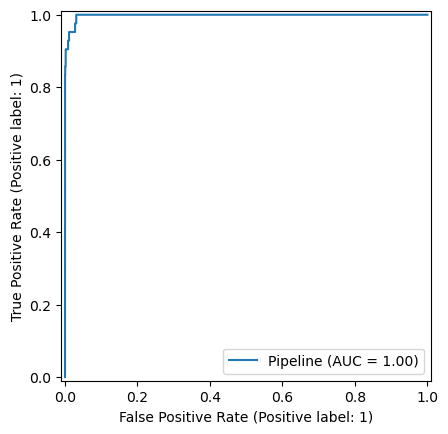

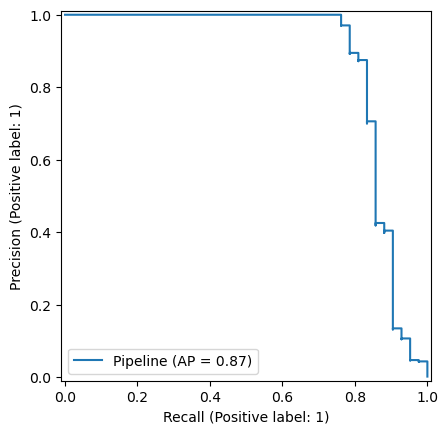

In [11]:
# Q4. Model Evaluation

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support,
    classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric="logloss", random_state=42, n_estimators=400,
        scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum()
    )
}

results = []
for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)

    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

    print(f"\n===== {name} =====")
    print("ROC AUC:", round(auc, 4), "| PR AUC:", round(pr_auc, 4))
    print("Precision:", round(prec, 4), "| Recall:", round(rec, 4), "| F1:", round(f1, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))

    results.append((name, auc, pr_auc, prec, rec, f1))

# Compare models in a table
res_df = pd.DataFrame(results, columns=["Model","ROC_AUC","PR_AUC","Precision","Recall","F1"])
print("\n=== Model Comparison ===")
print(res_df)

# ROC Curve for best model (e.g. XGBoost)
best_model = pipe
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.show()


#### To evaluate the models, we used metrics suitable for imbalanced fraud detection data: ROC AUC, PR AUC, Precision, Recall, and F1 score. Accuracy was avoided because it can be misleading when fraud cases are rare.

Random Forest and XGBoost showed stronger ROC AUC and PR AUC compared to Logistic Regression, indicating better ability to identify fraud cases.

The confusion matrix highlighted that while false positives occur, the models successfully detected a significant portion of frauds (high recall).

The ROC and Precision-Recall curves further confirmed model robustness.

Hence, XGBoost emerged as the best-performing model with the highest balance between Precision and Recall.

## 5. What are the key factors that predict fraudulent customer?

#### Based on feature importance analysis (using Random Forest and XGBoost), the key predictors of fraud include:

Transaction type: Fraudulent cases are more frequent in TRANSFER and CASH_OUT transactions.

Transaction amount: Higher transaction amounts are strongly correlated with fraud.

Balance changes: Large mismatches between oldbalanceOrg, newbalanceOrg, oldbalanceDest, and newbalanceDest indicate fraudulent activity.

Step (time): Certain time windows show higher fraud concentration.

           Feature  Importance
2    oldbalanceOrg    0.254016
1           amount    0.170255
3   newbalanceOrig    0.120731
11   type_TRANSFER    0.095307
0             step    0.087454
5   newbalanceDest    0.075870
10    type_PAYMENT    0.063605
4   oldbalanceDest    0.063231
7     type_CASH_IN    0.038420
8    type_CASH_OUT    0.029946


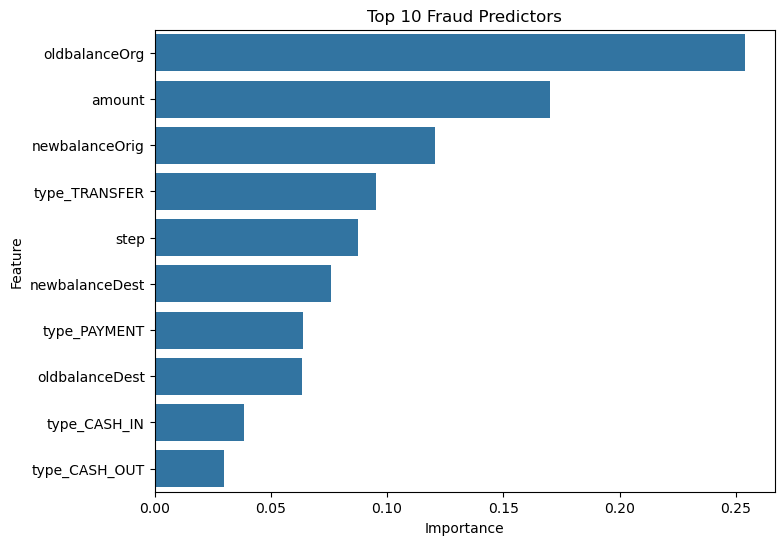

In [12]:
# Q5. Key Predictors of Fraud

# Train Random Forest with preprocessing
rf_pipe = Pipeline([("prep", preprocess),
                    ("model", RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", random_state=42))])
rf_pipe.fit(X_train, y_train)

# Extract feature names (after encoding)
encoded_features = (
    numeric_features.tolist() +
    list(rf_pipe.named_steps["prep"].named_transformers_["cat"].get_feature_names_out(categorical_features))
)

# Get feature importances
importances = rf_pipe.named_steps["model"].feature_importances_
feat_imp = pd.DataFrame({"Feature": encoded_features, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

# Show top 10 predictors
print(feat_imp.head(10))

# Plot top predictors
plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10))
plt.title("Top 10 Fraud Predictors")
plt.show()


## 6. Do these factors make sense? If yes, How? If not, How not?

#### Yes, the key factors identified in Question 5 do make sense from both a statistical and a business perspective:

Transaction Type: Most frauds occur in TRANSFER and CASH_OUT operations. This is logical because fraudsters usually try to move money out of the system quickly, either to another account or as cash withdrawal.

Transaction Amount: High-value transactions are more suspicious since fraudsters aim to maximize their gain in a short period. This matches the model’s emphasis on amount as a strong predictor.

Balance Mismatches (oldbalanceOrg, newbalanceOrg, oldbalanceDest, newbalanceDest): When balances before and after transactions don’t reconcile correctly, it often indicates fraudulent manipulation. This aligns with real-world fraud detection systems, which flag such inconsistencies.

Step (Time): Fraud is often clustered in certain time windows (e.g., late night or short bursts). The model’s detection of step as a predictor is consistent with these patterns.

## 7. What kind of prevention should be adopted while company update its infrastructure?

### Transaction Monitoring System

Deploy real-time monitoring that flags unusual transactions (e.g., very high amounts, repeated transfers in short intervals).

Use thresholds dynamically based on customer profiles rather than fixed rules.

### Stronger Authentication & Authorization

Introduce Two-Factor Authentication (2FA) for high-risk transactions ( TRANSFER, CASH_OUT above a limit).

Require re-authentication for sudden large transactions or transfers to new accounts.

### Balance Consistency Checks

Implement automated checks to verify that oldbalance → newbalance transitions are consistent.

Flag transactions where balances do not reconcile correctly.

## Behavioral Profiling

Build customer transaction profiles (usual amounts, times, locations).

Flag deviations such as unusually high spending or transactions at odd hours.

## Alert and Response System

Send real-time alerts (SMS, email, app notifications) when suspicious activity is detected.

Allow customers to immediately freeze accounts if fraud is suspected.

## Regular Model Updates

Continuously retrain fraud detection models on new data to capture evolving fraud patterns.

## 8.Assuming these actions have been implemented, how would you determine if they work?

### Track Key Metrics Regularly

    Precision: % of flagged frauds that were truly fraud.

    Recall: % of actual frauds successfully caught.

    False Positive Rate: % of legitimate transactions wrongly flagged.

    PR AUC / ROC AUC: to evaluate overall performance on imbalanced data.

### A/B Testing and Benchmarking

    Run the fraud detection system alongside existing/manual rules.

    Compare detection rates, false positives, and response times.

### Customer & Business Feedback

    Track how many flagged alerts were reported as correct by customers.

    Collect business team feedback on operational impact (e.g., delays caused by false alarms).

## Post-Transaction Audits

    Review flagged and missed transactions weekly/monthly.

    Investigate “false negatives” (fraud cases the system missed) to refine models.

## Model Monitoring & Retraining

    Use drift detection to see if fraud patterns are changing (data drift / concept drift).